## Erschließungsstrategien für unbekannten Wortschatz von DaF-Lernenden an spanischen Universitäten
# Datenanalyse der Hauptstudie 2018: Inferenzstatisik

##### Werkzeuge und Daten importieren

In [118]:
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import math
from scipy import stats
from biofes import biplot
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans, AgglomerativeClustering
from adjustText import adjust_text
import seaborn as sns
sns.set(style="whitegrid") #"white", "darkgrid"...
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
Daten = pd.read_pickle('D:\Daten\DISS\Daten\Estrategias_Estudiantes_2017-19_ber')

In [4]:
Daten.shape

(401, 377)

In [5]:
#Daten.head(3)

##### Untergruppen und Listen für die Analyse

In [6]:
Daten_A3 = Daten[Daten['A-Q3_27'] >= 1]

In [7]:
Daten_A3.shape

(396, 377)

In [8]:
Finished = Daten[Daten['C-Q1_7'] >= 1]

In [9]:
Finished.shape

(391, 377)

Liste erstellen:

In [10]:
Liste_A_Q2 = [col for col in Daten.columns if 'A-Q2' in col]

In [11]:
Liste_A_Q3 = [col for col in Daten.columns if 'A-Q3' in col]
Liste_A_Q3.pop(3)

'A-Q3_3_TEXT'

In [12]:
Liste_C_Q1 = [col for col in Finished.columns if 'C-Q1' in col]

In [13]:
Liste_D = ['D-Q1','D-Q2','D-Q2a','D-Q2b','D-Q3','D-Q4','D-Q5','D-Q6']

##### Visualisierung

Funktion für Grafiken:

In [14]:
def graf_hist(D,l,sx,sy,nrow,ncol):
    fig = plt.figure(figsize=(sx,sy))
    for i, col in enumerate(l):
        plt.subplot(nrow,ncol,i+1)
        plt.hist(D[col].dropna(),color = '#0063A6')
        plt.xticks([1,2,3,4,5])
        plt.title(col,size=13)
    plt.show()

Funktion für Darstellung der Likert-Skalen:

In [15]:
def graf_likert(D,l,sy):

    likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']

    df = D[l].apply(pd.value_counts).T
    middles = df[[1, 2]].sum(axis=1)+df[3]*.5
    longest = middles.max()
    complete_longest = df.sum(axis=1).max()
    df.insert(0, '', (middles - longest).abs())

    df.plot.barh(stacked=True, figsize=(8,sy), color=likert_colors, edgecolor='none', legend=False)
    z = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
    z.set_zorder(-1)

    plt.show()

In [24]:
def graf_diff(data,item,var):
    
    df = pd.crosstab(data[data[var]!=0][item],data[data[var]!=0][var])
    return df.plot(kind='bar')

In [25]:
def graf_diff_likert(data, item, var, arg1,*argv):

    data = data[(data[var]!=0) & (data[item]!=0)]
    likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']

    df = pd.DataFrame(data[data[var] == arg1][item].value_counts(normalize='True'))
    df = df.sort_index()
    df.rename(columns={item:str(arg1)}, inplace=True)
    print('n('+ str(arg1) + ')= ' + str(len(data[data[var] == arg1])))
    
    for arg in argv:
        df[str(arg)] = pd.Series(data[data[var] == arg][item].value_counts(normalize='True', sort='False'))
        print('n('+ str(arg) + ')= ' + str(len(data[data[var] == arg])))
    
    df.T.plot(kind='barh',stacked='True', color=likert_colors, legend=None)

In [147]:
def vector_to_shape(v):
    markers = ["p", "," , "o" , "v" , "x", "^", "D", "*", "1"]
    return [markers[el] for el in v]

In [148]:
def vector_to_color(v):
    col = ['orange','b', 'g', 'r', 'm', 'c', 'y', 'k', 'saddlebrown']
    return [col[el] for el in v]

In [209]:
def graf_biplot(data, dim, vcol, dim1 = 0, dim2 = 1, sx = 10, sy = 10):
    
    B = biplot.Classic(data, dim, method = 1) 
    R = B.RowCoord
    C = B.ColCoord
    
    fig = plt.figure(figsize=(sx,sy))
    ax = fig.add_subplot(111)
    
    color_v = vector_to_color(vcol)
    sh_v = vector_to_shape(vcol)
    
    for i in range(C.shape[0]):
        ax.arrow(0,0,C[i,dim1],C[i,dim2], alpha = 0.7)
        #ax.scatter(C[i,dim1],C[i,dim2]) # Hier würden Linien nicht angezeigt.
        ax.text(C[i,dim1],C[i,dim2],data.columns[i],fontsize=15, alpha = 0.7)

    for i in range(R.shape[0]):
        ax.scatter(R[i,dim1],R[i,dim2], s = 20, c = color_v[i], marker = sh_v[i])
    
    #markers = sh_v
    #colors = color_v
    #marks = [Line2D([], [], color=c, marker=markers, linestyle=None) for c in colors]
    #labels = [pd.Series(vcol.unique()).sort_values()]
    #marks = list(set(sh_v))
    #labels = list(vcol.unique())
    ax.legend(pd.Series(vcol.unique()).sort_values())
    texts = [plt.text(R[i,dim1],R[i,dim2], data.index[i], ha='center', va='center') for i in range(len(R[:,0]))];

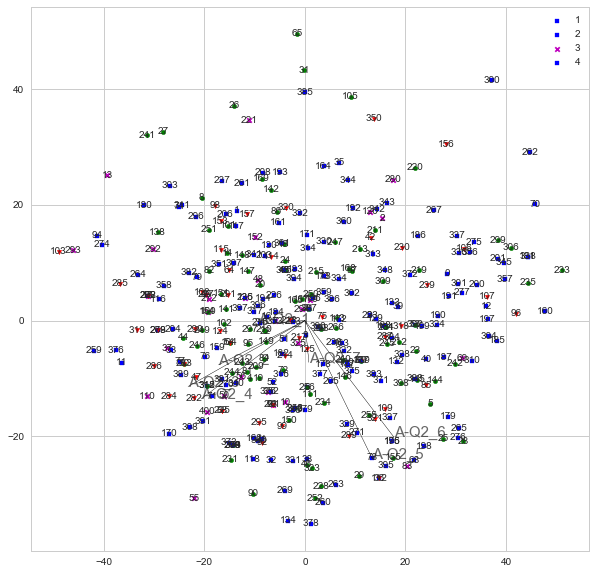

In [210]:
graf_biplot(Finished[Finished['D-Q2b']!=0][Liste_A_Q2],7,Finished[Finished['D-Q2b']!=0]['D-Q2b'])

##### Korrelation

Funktion, um Daten mit bestimmtem Korrelationswert (z.B. über 0,5) zu erhalten:

In [16]:
def get_max_corr(df,col,lim = 0.5):
    return df[(abs(df[col]) > lim) & (df[col].dropna() < 0.99)][col]

### Cronbach's Alpha berechnen

In [17]:
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    calpha = nitems / float(nitems-1) * (1 - itemvars.sum() / float(tscores.var(ddof=1)))

    return calpha

In [18]:
CronbachAlpha(Daten[Liste_A_Q2])

0.3018915225555093

In [19]:
CronbachAlpha(Daten_A3[Liste_A_Q3])

0.8845773413596196

In [20]:
CronbachAlpha(Finished[Liste_C_Q1])

0.4896684535094027

In [21]:
Liste_A_Q = Liste_A_Q2 + Liste_A_Q3

In [22]:
Liste_AC_Q = Liste_A_Q + Liste_C_Q1

In [23]:
CronbachAlpha(Daten[Liste_AC_Q])

0.918340317521501

### Analyse des Einflusses ausgewählter Variablen auf die Strategiennutzung

Untersuchte Bereiche: 
* A-Q2 (7 Hauptbereiche)
* A-Q3 (31 Einzelstrategien)
* C-Q1 (Einstellung zu Erschließungsstrategien)

Methoden:
* Unterschiedshypothesen: Mann-Whitney-U-Test oder Kruskal-Wallis-Test (Nullhypothese: Es gibt keinen Unterschied zwischen den untersuchten Gruppen in Bezug auf die abhängige Variable.)
* Zusammenhangshypothesen (Korrelationen): Spearman's Rho (Stärke der Korrelation zwischen Variablen)

Da Testvariablen auf Ordinalskalen-Niveau vorliegen, werden als nichtparametrische Verfahren der Mann-Whitney-U-Test (zum Vergleich zweier unabhängiger Gruppen) bzw. der Kruskal-Wallis-Test (für mehr als zwei Gruppen) durchgeführt.
Liegt der ermittelte p-Wert über 0,05 kann die Nullhypothese (ähnliche Gruppenvarianz) angenommen werden. Ein Wert unter 0,05 bedeutet, dass mindestens eine der untersuchten Gruppen abweichendes Antwortverhalten zeigt.

Zur Untersuchung der Korrelation zwischen ausgewählten Variablen wird Spearman's Rho berechnet, ebenfalls ein nichtparametrisches Verfahren. Je höher der errechnete Wert, desto höher die Korrelation. Zusätzlich wird überprüft, ob der errechnete Wert nicht auch zufällig zustandegekommen sein könnte. Der p-Wert gibt an, ob die Nullhypothese "Unzusammenhängende Daten würden denselben oder einen extremeren Rho-Wert ergeben." angenommen werden kann. Liegt der p-Wert demnach unter 0.05 können die Ergebnisse als aussagekräftig bezeichnet werden.

##### Vorbereitung der Daten für die Analyse

Studienrichtung:

In [26]:
Daten['D-Q2a_neu'] = 0

In [27]:
j=0
for i in Daten[Daten['D-Q2a']!=0]['D-Q2a']:
    if i == 1:
        Daten.loc[j,'D-Q2a_neu'] = 1
    elif i == 2:
        Daten.loc[j,'D-Q2a_neu'] = 2
    elif i == 3 or i == 4:
        Daten.loc[j,'D-Q2a_neu'] = 3
    else:
        Daten.loc[j,'D-Q2a_neu'] = 4
    j = j+1

Niveau:

In [28]:
Daten['D-Q4_neu'] = 0

j=0
for i in Daten[Daten['D-Q4']!=0]['D-Q4']:
    if i == 1:
        Daten.loc[j,'D-Q4_neu'] = 1
    elif i == 2:
        Daten.loc[j,'D-Q4_neu'] = 2
    elif i == 3:
        Daten.loc[j,'D-Q4_neu'] = 3
    elif i == 4:
        Daten.loc[j,'D-Q4_neu'] = 4
    else:
        Daten.loc[j,'D-Q4_neu'] = 5
    j = j+1

In [29]:
Daten['D-Q4_neu'].value_counts()

1    151
3    103
2     66
5     35
4     34
0     12
Name: D-Q4_neu, dtype: int64

Alter:

In [30]:
Daten['D-Q5_neu'] = 0

j=0
for i in Daten[Daten['D-Q5']!=0]['D-Q5']:
    if i <= 18:
        Daten.loc[j,'D-Q5_neu'] = 1
    elif i == 19:
        Daten.loc[j,'D-Q5_neu'] = 2
    elif i == 20 or i == 4:
        Daten.loc[j,'D-Q5_neu'] = 3
    else:
        Daten.loc[j,'D-Q5_neu'] = 4
    j = j+1

In [31]:
Daten['D-Q5_neu'].value_counts()

4    125
1    104
2     84
3     66
0     22
Name: D-Q5_neu, dtype: int64

Erstsprache Spanisch:

In [32]:
Daten['D-Q7_neu'] = 0

j=0
for i in Daten['D-Q7']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

j=0
for i in Daten['D-Q7c']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

j=0
for i in Daten['D-Q7e']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

363 Studierende haben Spanisch als eine ihrer Erstsprachen angegeben. Die übrigen 25 verteilen sich auf verschiedene Sprachen (13 TN haben diese Frage nicht beantwortet), darunter haben 5 Personen Katalanisch/Valencianisch und 4 Galicisch angegeben.

In [33]:
Daten['D-Q7b'].value_counts()

2    287
1    103
0     11
Name: D-Q7b, dtype: int64

103 Personen sind laut eigenen Angaben bi- oder trilingual.

Weitere Sprachkenntnisse:

In [34]:
Spr_cols = ['D-Q7','D-Q7c','D-Q7e','D-Q8_1','D-Q8_2','D-Q8_3','D-Q8_4','D-Q8_5','D-Q8_6','D-Q8_7']

In [35]:
l_germ = [9,15,39,19,36]
l_rom = [13,16,17]
l_slaw = [23,24,25,26,27,28,41,18,44]
l_asiat = [6,7,8,22,31,42,45]

In [36]:
Daten['D-Q8_fr'] = 0
Daten['D-Q8_gr'] = 0
Daten['D-Q8_lat'] = 0
Daten['D-Q8_germ'] = 0
Daten['D-Q8_rom'] = 0
Daten['D-Q8_slaw'] = 0
Daten['D-Q8_asiat'] = 0

In [37]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 10:
            Daten.loc[i,'D-Q8_fr'] = 1
            pass

In [38]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 20:
            Daten.loc[i,'D-Q8_gr'] = 1
            pass

In [39]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 21:
            Daten.loc[i,'D-Q8_lat'] = 1
            pass

In [40]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_germ:
            Daten.loc[i,'D-Q8_germ'] = 1
            pass

In [41]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_rom:
            Daten.loc[i,'D-Q8_rom'] = 1
            pass

In [42]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_slaw:
            Daten.loc[i,'D-Q8_slaw'] = 1
            pass

In [43]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_asiat:
            Daten.loc[i,'D-Q8_asiat'] = 1
            pass

Strategienerwerbskontexte:

In [44]:
erwerb = {'E1': ['B-Q2-1_1','B-Q2-1_2','B-Q2-1_3','B-Q2-1_4','B-Q2-1_5','B-Q2-1_6','B-Q2-1_7'], 
         'E2': ['B-Q2-2_1','B-Q2-2_2','B-Q2-2_3','B-Q2-2_4','B-Q2-2_5','B-Q2-2_6','B-Q2-2_7'],
         'E3': ['B-Q2-3_1','B-Q2-3_2','B-Q2-3_3','B-Q2-3_4','B-Q2-3_5','B-Q2-3_6','B-Q2-3_7'],
         'E4': ['B-Q2-4_1','B-Q2-4_2','B-Q2-4_3','B-Q2-4_4','B-Q2-4_5','B-Q2-4_6','B-Q2-4_7'],
         'E5': ['B-Q2-5_1','B-Q2-5_2','B-Q2-5_3','B-Q2-5_4','B-Q2-5_5','B-Q2-5_6','B-Q2-5_7'],
         'E6': ['B-Q2-6_1','B-Q2-6_2','B-Q2-6_3','B-Q2-6_4','B-Q2-6_5','B-Q2-6_6','B-Q2-6_7'],
         'E7': ['B-Q2-7_1','B-Q2-7_2','B-Q2-7_3','B-Q2-7_4','B-Q2-7_5','B-Q2-7_6','B-Q2-7_7'],
         'E8': ['B-Q2-8_1','B-Q2-8_2','B-Q2-8_3','B-Q2-8_4','B-Q2-8_5'],
         'E9': ['B-Q2-9_1','B-Q2-9_2','B-Q2-9_3','B-Q2-9_4','B-Q2-9_5']}

* 1- En las clases de Lengua y Literatura en el colegio o instituto
* 2- En las clases de inglés en el colegio o instituto
* 3- En otras clases de idiomas en el colegio o instituto
* 4- En clases de alemán anteriores en la Universidad
* 5- En otras asignaturas de mi carrera universitaria
* 6- En clases de lenguas en escuelas de idiomas o academias
* 7- En mi curso de alemán actual
* 8- En mi familia, con mis amigos/as o compañeros/as de clase
* 9- Por mi cuenta, sin ayuda de otras personas
* 10- Otros:
* 11- No sé cómo he aprendido estas estrategias.

In [45]:
Daten['B-Q2_E1'] = 0
Daten['B-Q2_E2'] = 0
Daten['B-Q2_E3'] = 0
Daten['B-Q2_E4'] = 0
Daten['B-Q2_E5'] = 0
Daten['B-Q2_E6'] = 0
Daten['B-Q2_E7'] = 0
Daten['B-Q2_E8'] = 0
Daten['B-Q2_E9'] = 0

In [46]:
def add_columns(data,lst,col_neu):
    for i in data.index:
        for el in data.loc[i,lst]:
            if el == 1:
                data.loc[i,col_neu] = 1
                pass

In [47]:
add_columns(Daten,erwerb['E1'],'B-Q2_E1')

In [48]:
add_columns(Daten,erwerb['E2'],'B-Q2_E2')

In [49]:
add_columns(Daten,erwerb['E3'],'B-Q2_E3')

In [50]:
add_columns(Daten,erwerb['E4'],'B-Q2_E4')

In [51]:
add_columns(Daten,erwerb['E5'],'B-Q2_E5')

In [52]:
add_columns(Daten,erwerb['E6'],'B-Q2_E6')

In [53]:
add_columns(Daten,erwerb['E7'],'B-Q2_E7')

In [54]:
add_columns(Daten,erwerb['E8'],'B-Q2_E8')

In [55]:
add_columns(Daten,erwerb['E9'],'B-Q2_E9')

Methoden des Strategienerwerbs:

In [56]:
erwerb1 = {'U1': ['B-Q2-1_1','B-Q2-2_1','B-Q2-3_1','B-Q2-4_1','B-Q2-5_1','B-Q2-6_1','B-Q2-7_1'], 
         'U2': ['B-Q2-1_2','B-Q2-2_2','B-Q2-3_2','B-Q2-4_2','B-Q2-5_2','B-Q2-6_2','B-Q2-7_2'],
         'U3': ['B-Q2-1_3','B-Q2-2_3','B-Q2-3_3','B-Q2-4_3','B-Q2-5_3','B-Q2-6_3','B-Q2-7_3'],
         'U4': ['B-Q2-1_4','B-Q2-2_4','B-Q2-3_4','B-Q2-4_4','B-Q2-5_4','B-Q2-6_4','B-Q2-7_4'],
         'U5': ['B-Q2-1_5','B-Q2-2_5','B-Q2-3_5','B-Q2-4_5','B-Q2-5_5','B-Q2-6_5','B-Q2-7_5'],
         'U6': ['B-Q2-1_6','B-Q2-2_6','B-Q2-3_6','B-Q2-4_6','B-Q2-5_6','B-Q2-6_6','B-Q2-7_6']}

* (1)	Las estrategias se presentaron (y explicaron) en clase.
* (2)	El/La profesor/a dio consejos sobre cómo familiarizarse de manera autónoma con estas estrategias, p. ej. mediante páginas web, libros u otros materiales que explican estrategias de aprendizaje. 
* (3)	Estas estrategias se explicaron y practicaron con ejemplos concretos, realizando tareas, p. ej. leyendo un texto difícil.
* (4)	Se probaron y se compararon diferentes estrategias.
* (5)	Se reflexionó sobre el uso de estas estrategias, p. ej. sobre qué estrategia sería adecuada en una situación y/o para una persona determinada.
* (6)	Durante las clases he aprendido estas estrategias de manera inconsciente, p. ej. mientras leía textos difíciles, sin explicación o indicación del/de la profesor/a.
* (7)	Otros:

In [57]:
Daten['B-Q2_U1'] = 0
Daten['B-Q2_U2'] = 0
Daten['B-Q2_U3'] = 0
Daten['B-Q2_U4'] = 0
Daten['B-Q2_U5'] = 0
Daten['B-Q2_U6'] = 0

In [58]:
add_columns(Daten,erwerb1['U1'],'B-Q2_U1')

In [59]:
add_columns(Daten,erwerb1['U2'],'B-Q2_U2')

In [60]:
add_columns(Daten,erwerb1['U3'],'B-Q2_U3')

In [61]:
add_columns(Daten,erwerb1['U4'],'B-Q2_U4')

In [62]:
add_columns(Daten,erwerb1['U5'],'B-Q2_U5')

In [63]:
add_columns(Daten,erwerb1['U6'],'B-Q2_U6')

Kombinierter Strategieneinsatz:

In [64]:
strat = {'S1': ['A-Q3_5','A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9'], 
         'S2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
         'S3': ['A-Q3_9','A-Q3_10','A-Q3_11','A-Q3_12'],
         'S4': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         'S4a': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16'],
         'S4b': ['A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         'S5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24','A-Q3_25'],
         'S6': ['A-Q3_26','A-Q3_27','A-Q3_28','A-Q3_29','A-Q3_30','A-Q3_31']}

* S1: Auf Wortebene - intralingual
* S2: Auf Wortebene - interlingual
* S3: Auf Satz- und Textebene - engerer Kontext
* S4: Auf Satz- und Textebene - weiterer Kontext (S4a: intratextuell, S4b: Bezug zu Fach- und Weltwissen)
* S5: Außersprachlicher Kontext
* S6: Metakognitive Strategien

In [65]:
Daten['A-Q4'] = 0

In [225]:
for i in Daten.index:
    el = Daten.loc[i,strat['S1']]
    media, numer = el.mean(), el[el>=3].count()
    if media >= 3 and numer >= 2:
        Daten.loc[i,'A-Q4'] = 1

In [226]:
Daten['A-Q4'].value_counts()

1    303
0     98
Name: A-Q4, dtype: int64

Erhebungssituation:

Universitäten:

In [67]:
Daten['D-Q1_Sal'] = 0
Daten['D-Q1_Sev'] = 0
Daten['D-Q1_Vigo'] = 0
Daten['D-Q1_Gran'] = 0
Daten['D-Q1_Sant'] = 0
Daten['D-Q1_Madrid'] = 0

In [68]:
j=0
for i in Daten['D-Q1']:
    if i == 63:
        Daten.loc[j,'D-Q1_Sal'] = 1
    j = j+1

In [69]:
j=0
for i in Daten['D-Q1']:
    if i == 67:
        Daten.loc[j,'D-Q1_Sev'] = 1
    j = j+1

In [70]:
j=0
for i in Daten['D-Q1']:
    if i == 73:
        Daten.loc[j,'D-Q1_Vigo'] = 1
    j = j+1

In [71]:
j=0
for i in Daten['D-Q1']:
    if i == 29:
        Daten.loc[j,'D-Q1_Gran'] = 1
    j = j+1

In [72]:
j=0
for i in Daten['D-Q1']:
    if i == 66:
        Daten.loc[j,'D-Q1_Sant'] = 1
    j = j+1

In [73]:
j=0
for i in Daten['D-Q1']:
    if i == 20:
        Daten.loc[j,'D-Q1_Madrid'] = 1
    j = j+1

In [74]:
Daten['D-Q1_Madrid'].value_counts()

0    375
1     26
Name: D-Q1_Madrid, dtype: int64

In [75]:
Finished = Daten[Daten['Finished']==1]

##### Übersicht

In [77]:
def df_mannwhitneyu(data,var,lst,v1,v2):
    
    mannwhitneyu_test = []
    for col in lst:    
        mannwhitneyu_test.append(stats.mannwhitneyu(data[col][data[var]==v1],
                      data[col][data[var]==v2]).pvalue)
    
    df = pd.DataFrame(mannwhitneyu_test)
    df.index = [lst[ind] for ind in df.index]
    df_result = df[df[0] < 0.05]
    df_result.rename(columns={0:str(var)}, inplace=True)
    df_result = df_result.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df_result

In [78]:
def df_test(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:    
        Studium.append(stats.kruskal(data[data[var1]!=0][col][data[var1]==1],
                        data[data[var1]!=0][col][data[var1]==2],
                        data[data[var1]!=0][col][data[var1]==3],
                        data[data[var1]!=0][col][data[var1]==4]).pvalue)

    Studienjahr = []
    for col in lst:    
        Studienjahr.append(stats.kruskal(data[data[var2]!=0][col][data[var2]==1],
                        data[data[var2]!=0][col][data[var2]==2],
                        data[data[var2]!=0][col][data[var2]==3],
                        data[data[var2]!=0][col][data[var2]==4]).pvalue)

    Niveau_Deutschkurs = []
    for col in lst:    
        Niveau_Deutschkurs.append(stats.kruskal(data[data[var3]!=0][col][data[var3]==1],
                        data[data[var3]!=0][col][data[var3]==2],
                        data[data[var3]!=0][col][data[var3]==3],
                        data[data[var3]!=0][col][data[var3]==4],
                        data[data[var3]!=0][col][data[var3]==5]).pvalue)

    Alter = []
    for col in lst:    
        Alter.append(stats.kruskal(data[data[var4]!=0][col][data[var4]==1],
                        data[data[var4]!=0][col][data[var4]==2],
                        data[data[var4]!=0][col][data[var4]==3],
                        data[data[var4]!=0][col][data[var4]==4]).pvalue)

    Geschlecht = []
    for col in lst:    
        Geschlecht.append(stats.mannwhitneyu(data[data[var5]!=0][col][data[var5]==1],
                        data[data[var5]!=0][col][data[var5]==2]).pvalue) 

    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [79]:
def df_test2(data,lst):

    var1 = 'D-Q7'
    var2 = 'D-Q7b'
    var3 = 'D-Q8_fr'
    var4 = 'D-Q8_gr'
    var5 = 'D-Q8_lat'
    var6 = 'D-Q8_germ'
    var7 = 'D-Q8_rom'
    var8 = 'D-Q8_slaw'
    var9 = 'D-Q8_asiat'

    Erstspr_Sp = []
    for col in lst:    
        Erstspr_Sp.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    Erstspr_bi = []
    for col in lst:    
        Erstspr_bi.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==2]).pvalue)
    
    Franz = []
    for col in lst:    
        Franz.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    Altgriech = []
    for col in lst:    
        Altgriech.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    Latein = []
    for col in lst:    
        Latein.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    Germ = []
    for col in lst:    
        Germ.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
        
    Rom = []
    for col in lst:    
        Rom.append(stats.mannwhitneyu(data[col][data[var7]==1],
                        data[col][data[var7]==0]).pvalue)
         
    Slaw = []
    for col in lst:    
        Slaw.append(stats.mannwhitneyu(data[col][data[var8]==1],
                        data[col][data[var8]==0]).pvalue)
    
    Asiat = []
    for col in lst:    
        Asiat.append(stats.mannwhitneyu(data[col][data[var9]==1],
                        data[col][data[var9]==0]).pvalue)
    
    df = pd.DataFrame(Erstspr_Sp)
    df.rename(columns={0:'Erstspr_Sp'}, inplace=True)
    df['Erstspr_bi'] = Erstspr_bi
    df['Franz'] = Franz
    df['Altgriech'] = Altgriech
    df['Latein'] = Latein
    df['Germ'] = Germ
    df['Rom'] = Rom
    df['Slaw'] = Slaw
    df['Asiat'] = Asiat

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [80]:
def df_test3(data,lst):

    var1 = 'B-Q2_E1'
    var2 = 'B-Q2_E2'
    var3 = 'B-Q2_E3'
    var4 = 'B-Q2_E4'
    var5 = 'B-Q2_E5'
    var6 = 'B-Q2_E6'
    var7 = 'B-Q2_E7'
    var8 = 'B-Q2_E8'
    var9 = 'B-Q2_E9'

    E1 = []
    for col in lst:    
        E1.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    E2 = []
    for col in lst:    
        E2.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==0]).pvalue)
    
    E3 = []
    for col in lst:    
        E3.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    E4 = []
    for col in lst:    
        E4.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    E5 = []
    for col in lst:    
        E5.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    E6 = []
    for col in lst:    
        E6.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
        
    E7 = []
    for col in lst:    
        E7.append(stats.mannwhitneyu(data[col][data[var7]==1],
                        data[col][data[var7]==0]).pvalue)
         
    E8 = []
    for col in lst:    
        E8.append(stats.mannwhitneyu(data[col][data[var8]==1],
                        data[col][data[var8]==0]).pvalue)
    
    E9 = []
    for col in lst:    
        E9.append(stats.mannwhitneyu(data[col][data[var9]==1],
                        data[col][data[var9]==0]).pvalue)
    
    df = pd.DataFrame(E1)
    df.rename(columns={0:'E1'}, inplace=True)
    df['E2'] = E2
    df['E3'] = E3
    df['E4'] = E4
    df['E5'] = E5
    df['E6'] = E6
    df['E7'] = E7
    df['E8'] = E8
    df['E9'] = E9

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [81]:
def df_test4(data,lst):

    var1 = 'B-Q2_U1'
    var2 = 'B-Q2_U2'
    var3 = 'B-Q2_U3'
    var4 = 'B-Q2_U4'
    var5 = 'B-Q2_U5'
    var6 = 'B-Q2_U6'

    U1 = []
    for col in lst:    
        U1.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    U2 = []
    for col in lst:    
        U2.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==0]).pvalue)
    
    U3 = []
    for col in lst:    
        U3.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    U4 = []
    for col in lst:    
        U4.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    U5 = []
    for col in lst:    
        U5.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    U6 = []
    for col in lst:    
        U6.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
    
    df = pd.DataFrame(U1)
    df.rename(columns={0:'U1'}, inplace=True)
    df['U2'] = U2
    df['U3'] = U3
    df['U4'] = U4
    df['U5'] = U5
    df['U6'] = U6

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [82]:
def df_test5(data,lst):

    var1 = 'D-Q9_1'
    var2 = 'pilot'
    var3 = 'D-Q1_Sal'
    var4 = 'D-Q1_Sev'
    var5 = 'D-Q1_Vigo'
    var6 = 'D-Q1_Gran'
    var7 = 'D-Q1_Sant'
    var8 = 'D-Q1_Madrid'

    Erh_sit = []
    for col in lst:    
        Erh_sit.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    pilot = []
    for col in lst:    
        pilot.append(stats.mannwhitneyu(data[data['D-Q1']==63][col][data[var2]==1],
                        data[data['D-Q1']==63][col][data[var2]==0]).pvalue)
    
    Sal = []
    for col in lst:    
        Sal.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    Sev = []
    for col in lst:    
        Sev.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var4]==1],
                        data[data['D-Q1']!=63][col][data[var4]==0]).pvalue)
    
    Vigo = []
    for col in lst:    
        Vigo.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var5]==1],
                        data[data['D-Q1']!=63][col][data[var5]==0]).pvalue)
            
    Gran = []
    for col in lst:    
        Gran.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var6]==1],
                        data[data['D-Q1']!=63][col][data[var6]==0]).pvalue)
    
    Sant = []
    for col in lst:    
        Sant.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var7]==1],
                        data[data['D-Q1']!=63][col][data[var7]==0]).pvalue)
    
    Madrid = []
    for col in lst:    
        Madrid.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var8]==1],
                        data[data['D-Q1']!=63][col][data[var8]==0]).pvalue)
    
    df = pd.DataFrame(Erh_sit)
    df.rename(columns={0:'Erh_sit'}, inplace=True)
    df['pilot'] = pilot
    df['Sal'] = Sal
    df['Sev'] = Sev
    df['Vigo'] = Vigo
    df['Gran'] = Gran
    df['Sant'] = Sant
    df['Madrid'] = Madrid
    
    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [83]:
def df_spearman(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:
        corr1, p1 = stats.spearmanr(data[col],data[var1])
        Studium.append(corr1)
   
    Studienjahr = []
    for col in lst:
        corr2, p2 = stats.spearmanr(data[col],data[var2])
        Studienjahr.append(corr2)

    Niveau_Deutschkurs = []
    for col in lst:    
        corr3, p3 = stats.spearmanr(data[col],data[var3])
        Niveau_Deutschkurs.append(corr3)
    
    Alter = []
    for col in lst:    
        corr4, p4 = stats.spearmanr(data[col],data[var4])
        Alter.append(corr4)
    
    Geschlecht = []
    for col in lst:    
        corr5, p5 = stats.spearmanr(data[col],data[var5])
        Geschlecht.append(corr5)
    
    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if abs(x) > 0.5 
                           else 'background-color: lightsalmon' if abs(x) > 0.3 and abs(x) <= 0.5
                           else 'background-color: peachpuff' if abs(x) > 0.1 and abs(x) <= 0.3
                           else 'background-color : white')
    
    return df

In [84]:
def df_spearman_pv(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:
        corr1, p1 = stats.spearmanr(data[col],data[var1])
        Studium.append(p1)
   
    Studienjahr = []
    for col in lst:
        corr2, p2 = stats.spearmanr(data[col],data[var2])
        Studienjahr.append(p2)

    Niveau_Deutschkurs = []
    for col in lst:    
        corr3, p3 = stats.spearmanr(data[col],data[var3])
        Niveau_Deutschkurs.append(p3)
    
    Alter = []
    for col in lst:    
        corr4, p4 = stats.spearmanr(data[col],data[var4])
        Alter.append(p4)
    
    Geschlecht = []
    for col in lst:    
        corr5, p5 = stats.spearmanr(data[col],data[var5])
        Geschlecht.append(p5)
    
    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x <= 0.05 
                           else 'background-color : white')
    
    return df

##### Personenbezogene Variablen  

In [87]:
df_test(Finished,Liste_A_Q2)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q2_1,0.861716,0.325857,0.206268,0.168283,0.279876
A-Q2_2,0.458574,0.0126992,0.153774,0.182993,0.00295193
A-Q2_3,0.459066,0.00143487,1.13393e-06,2.35926e-05,0.425105
A-Q2_4,0.612995,0.000737787,0.000766486,0.0364326,0.334646
A-Q2_5,0.0753744,0.126093,0.0299028,0.448371,0.145531
A-Q2_6,0.420258,0.0970393,0.104323,0.830679,0.00706355
A-Q2_7,0.497342,0.0518779,0.000273239,0.0425691,0.425299


In [88]:
df_test(Finished,Liste_A_Q3)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q3_1,0.718766,0.324387,0.137,0.524765,0.15836
A-Q3_2,0.687633,0.0743167,0.167948,0.379556,0.127954
A-Q3_3,0.0461003,0.539241,0.20516,0.63598,0.41581
A-Q3_4,0.511128,0.210857,0.0238946,0.840159,0.0159038
A-Q3_5,0.317178,0.0074459,0.050103,0.991811,0.27319
A-Q3_6,0.512935,5.40209e-05,8.92328e-08,0.00508136,0.286744
A-Q3_7,0.468818,8.26349e-07,2.81962e-10,0.00195816,0.251741
A-Q3_8,0.0824661,3.26159e-05,9.34152e-11,6.69927e-05,0.338006
A-Q3_9,0.0702715,0.00218312,0.0011927,0.172705,0.192495
A-Q3_28,0.599182,0.00251211,0.15363,0.35537,0.440627


In [89]:
df_test(Finished,Liste_C_Q1)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
C-Q1_1,0.289751,0.0176508,0.032553,0.013105,0.336042
C-Q1_2,0.710204,0.558295,0.0288777,0.548266,0.353475
C-Q1_3,0.420247,0.0176669,0.0150643,0.704054,0.0544477
C-Q1_4,0.124659,0.0991862,0.0181235,8.9333e-05,0.444205
C-Q1_5,0.298107,0.0292912,0.326933,0.0158317,0.409249
C-Q1_6,0.412963,0.183881,0.986074,0.025572,0.116397
C-Q1_7,0.371045,0.285857,0.651416,0.0193106,0.188986


In [132]:
df_spearman(Finished,Liste_A_Q2)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q2_1,0.0184975,-0.0578602,0.0211934,0.0708098,0.0384076
A-Q2_2,-0.0959116,-0.058524,-0.0867712,0.0676783,0.145577
A-Q2_3,-0.0228836,0.131103,0.259548,0.19811,0.00528458
A-Q2_4,-0.0601453,0.112568,0.186268,0.114027,0.0197505
A-Q2_5,-0.182487,-0.0661272,-0.190237,-0.0280817,-0.0243453
A-Q2_6,-0.0758915,-0.07967,-0.122009,0.00529321,-0.102861
A-Q2_7,0.0706016,0.17535,0.161149,0.100409,0.0306288


In [133]:
df_spearman(Finished,Liste_A_Q3)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q3_1,0.0257575,-0.0748436,-0.0324192,0.0137284,0.0643286
A-Q3_2,-0.0356895,-0.0476281,-0.0842275,-0.0344582,0.0729916
A-Q3_3,-0.149657,-0.046212,-0.0994902,-0.00949256,0.00660861
A-Q3_4,0.0682142,-0.0337777,-0.0920461,-0.0152196,-0.0628978
A-Q3_5,-0.0490709,-0.0695591,0.0164324,0.00964436,0.0222548
A-Q3_6,0.00673765,0.143252,0.294848,0.192775,0.0238553
A-Q3_7,0.0758419,0.179766,0.348607,0.205826,-0.00816626
A-Q3_8,-0.0339574,0.166213,0.338161,0.202955,0.029439
A-Q3_9,-0.110896,0.138166,0.172971,0.0728299,-0.0455453
A-Q3_28,0.0192339,0.054373,0.104529,0.0911894,-0.0169906


In [134]:
df_spearman(Finished,Liste_C_Q1)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
C-Q1_1,0.0312548,0.0627273,0.133303,0.0645753,-0.046856
C-Q1_2,0.0144301,-0.0816122,-0.155006,0.0424787,0.0472148
C-Q1_3,-0.0344238,0.0600809,0.169897,0.0515854,0.0821218
C-Q1_4,0.0529244,0.0869236,0.15172,0.166927,0.0361898
C-Q1_5,-0.00453121,0.0885933,0.0934733,0.126552,0.0505437
C-Q1_6,-0.0624782,0.0819736,0.0326192,0.166735,0.0789863
C-Q1_7,0.0363584,-0.0438094,-0.0702101,-0.146623,-0.0579939


In [92]:
#df_spearman_pv(Daten,Liste_A_Q2)

Die Überprüfung der p-Werte hat ergeben, dass es sich bei den errechneten Werten um keine zufälligen Korrelationen handelt.

In [93]:
#df_spearman_pv(Daten,Liste_A_Q3)

No handles with labels found to put in legend.


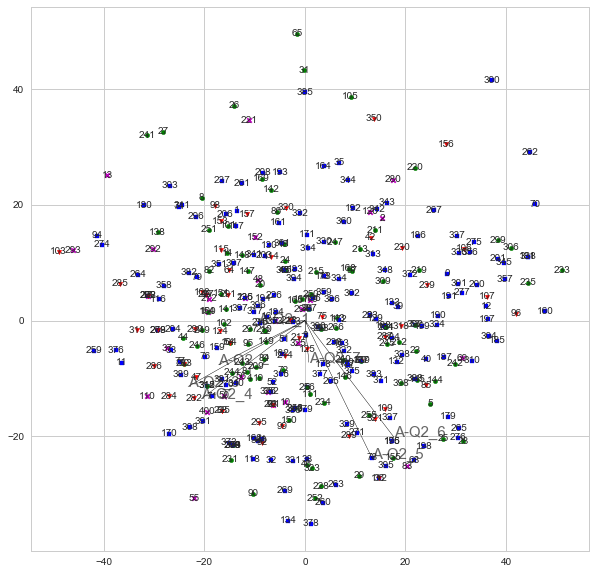

In [176]:
graf_biplot(Finished[Finished['D-Q2b']!=0][Liste_A_Q2],7,Finished[Finished['D-Q2b']!=0]['D-Q2b'])

In [172]:
Finished['D-Q2b'][56]

4

In [94]:
df_test2(Finished,Liste_A_Q2)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
A-Q2_1,0.482667,0.190228,0.0963055,0.208085,0.43507,0.105034,0.0957262,0.413845,0.475264
A-Q2_2,0.209549,0.46089,0.242011,0.334106,0.440307,0.00732996,0.105179,0.10621,0.316994
A-Q2_3,0.186106,0.325804,0.18347,0.167178,0.280041,0.00249991,0.00509267,0.117962,0.34653
A-Q2_4,0.332451,0.459077,0.309011,0.348082,0.129806,0.000138317,0.0329131,0.15408,0.484624
A-Q2_5,0.185146,0.393787,0.0091305,0.179259,0.0355658,0.269703,0.323969,0.219267,0.0782595
A-Q2_6,0.390459,0.37136,0.00911673,0.185454,0.0291609,0.200478,0.138551,0.00705916,0.430327
A-Q2_7,0.0948564,0.295197,0.268505,0.210965,0.258598,0.283978,0.0489764,0.454109,0.474152


In [95]:
df_test2(Finished,Liste_A_Q3)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
A-Q3_1,0.0134332,0.247371,0.106896,0.272676,0.476217,0.0612518,0.00872431,0.436799,0.377797
A-Q3_2,0.0541705,0.0599035,0.272408,0.253684,0.311026,0.0795338,0.349366,0.466178,0.105728
A-Q3_3,0.0286793,0.225585,0.0412368,0.0887467,0.408421,0.00191444,0.185473,0.0389049,0.0630173
A-Q3_4,0.0488117,0.342023,0.00992478,0.367274,0.357163,0.233246,0.406361,0.229507,0.116131
A-Q3_5,0.451851,0.154361,0.439207,0.122936,0.375043,0.0231618,0.0193208,0.187996,0.0239429
A-Q3_6,0.396776,0.491084,0.172421,0.231927,0.283662,0.0148944,0.243079,0.0706147,0.126849
A-Q3_7,0.413002,0.168468,0.348892,0.0708275,0.0496516,0.00732952,0.0839307,0.0317587,0.124092
A-Q3_8,0.395996,0.102709,0.468997,0.0124888,0.00973692,0.000547896,0.397231,0.251842,0.259938
A-Q3_9,0.259504,0.0325399,0.392237,0.146233,0.109414,0.00087404,0.124746,0.0464295,0.377362
A-Q3_28,0.407576,0.0989248,0.108149,0.102716,0.233834,0.0250183,0.138557,0.0149333,0.445073


In [96]:
df_test2(Finished,Liste_C_Q1)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
C-Q1_1,0.255259,0.320908,0.16448,0.463221,0.143519,0.00655009,0.0453963,0.0411635,0.212051
C-Q1_2,0.123613,0.246138,0.179813,0.107519,0.243505,0.225683,0.0140895,0.410978,0.116875
C-Q1_3,0.449062,0.372839,0.275128,0.216334,0.408781,5.8185e-06,0.110563,0.000115082,0.00806101
C-Q1_4,0.120262,0.293681,0.191012,0.0497555,0.121394,0.108021,0.060169,0.243941,0.494557
C-Q1_5,0.493165,0.182565,0.439795,0.238779,0.254283,0.0155671,0.0106723,0.117119,0.381101
C-Q1_6,0.0865372,0.215642,0.330492,0.260155,0.0266685,0.00152597,0.335054,0.465446,0.03308
C-Q1_7,0.0224054,0.27346,0.109332,0.487654,0.493327,0.434874,0.314149,0.443166,0.319621


In [97]:
df_test3(Finished,Liste_A_Q2)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
A-Q2_1,0.49378,0.444053,0.283473,0.399399,0.0258077,0.358996,0.483507,0.173157,0.209704
A-Q2_2,0.374349,0.356219,0.140799,0.291892,0.0821503,0.158093,0.027317,0.257878,0.00280428
A-Q2_3,0.482022,0.29223,0.00793167,4.39746e-05,3.76462e-06,0.042728,0.180891,0.00523911,0.0202842
A-Q2_4,0.0935396,0.318228,0.276689,0.000150556,0.00275364,0.0501087,0.00204329,0.00476239,0.0319838
A-Q2_5,0.00517345,0.00500057,0.0467035,0.184772,0.383895,0.0343721,0.00608435,0.37432,0.203177
A-Q2_6,0.19595,0.000603458,0.0155172,0.00337626,0.237401,0.188267,0.075076,0.305911,0.00912113
A-Q2_7,0.28599,0.442332,0.05242,0.0481501,0.316062,0.0217097,0.0129721,0.238647,0.486091


In [98]:
df_test3(Finished,Liste_A_Q3)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
A-Q3_1,0.430694,0.0762605,0.0301392,0.166078,0.283826,0.211762,0.0646173,0.261398,0.181119
A-Q3_2,0.304775,0.00920999,0.0523262,0.0380489,0.33652,0.406696,0.384596,0.0940453,0.118636
A-Q3_3,0.493677,0.0922206,0.00296696,0.142066,0.32068,0.241283,0.238884,0.459496,0.0351946
A-Q3_4,0.470563,0.139599,0.210369,0.133151,0.315,0.159598,0.275518,0.0345711,0.427905
A-Q3_5,0.128154,0.381043,0.0195554,0.401571,0.0530219,0.318169,0.492868,0.152693,0.298488
A-Q3_6,0.00644985,0.306507,0.0412867,0.00128789,0.0013961,0.0902024,0.265012,0.00863803,0.0608667
A-Q3_7,0.189561,0.119728,0.0570996,2.3944e-05,2.07588e-05,0.207972,0.184271,0.0462629,0.0950379
A-Q3_8,0.0548808,0.0244408,0.368759,8.92455e-05,4.9796e-06,0.185143,0.23922,0.0511423,0.00178513
A-Q3_9,0.246445,0.414741,0.463682,0.000138747,0.000166631,0.0589254,0.032746,0.0283595,0.00134012
A-Q3_28,0.125461,0.156901,0.140691,0.013475,0.0272367,0.179904,0.0371542,0.00217762,0.130456


In [99]:
df_test3(Finished,Liste_C_Q1)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
C-Q1_1,0.023853,0.193494,0.159266,0.338905,0.00615263,0.455685,0.156928,0.0183788,0.00453191
C-Q1_2,0.0320839,0.0259582,0.013764,0.144959,0.0463571,0.419601,0.00897872,0.403365,0.224211
C-Q1_3,0.0183371,0.0963517,0.212522,0.0485834,0.00585558,0.257579,0.0763913,0.0538626,0.0076986
C-Q1_4,0.346671,0.305555,0.432337,0.0059743,0.0259004,0.201647,0.00517378,0.0788012,0.0541259
C-Q1_5,0.393336,0.165803,0.270206,0.126279,0.000437044,0.293179,0.0272636,0.195059,0.0466985
C-Q1_6,0.218827,0.360078,0.275213,0.104851,2.55576e-05,0.240573,0.0287954,0.150345,0.492701
C-Q1_7,0.188723,0.232464,0.0431042,0.218171,0.164495,0.123763,0.00236505,0.0426596,0.365479


In [100]:
df_test4(Finished,Liste_A_Q2)

,U1,U2,U3,U4,U5,U6
A-Q2_1,0.209211,0.0598179,0.0923377,0.300915,0.360079,0.291934
A-Q2_2,0.173046,0.343757,0.172517,0.0650371,0.0108366,0.0230903
A-Q2_3,0.150018,0.0369125,0.0441735,0.00274545,0.000631001,0.020431
A-Q2_4,0.258065,0.455679,0.0486804,0.0274783,0.325265,0.000538525
A-Q2_5,0.061453,0.163256,0.0138595,0.394778,0.0896321,0.356745
A-Q2_6,0.303697,0.0348541,0.0382399,0.312703,0.172759,0.499409
A-Q2_7,0.330794,0.0504621,0.0231831,0.481144,0.182686,0.192923


In [101]:
df_test4(Finished,Liste_A_Q3)

,U1,U2,U3,U4,U5,U6
A-Q3_1,0.39716,0.283206,0.403982,0.302912,0.163727,0.00311441
A-Q3_2,0.431834,0.111725,0.0458044,0.27304,0.152965,0.00197753
A-Q3_3,0.263703,0.107811,0.12942,0.0313569,0.00172316,0.0430252
A-Q3_4,0.365705,0.254119,0.147452,0.0637012,0.269884,0.280231
A-Q3_5,0.302696,0.0263312,0.239125,0.0122395,0.401528,0.146346
A-Q3_6,0.455892,0.259122,0.455349,0.0951489,0.359714,0.0998038
A-Q3_7,0.484804,0.36052,0.270054,0.0377218,0.48454,0.0320985
A-Q3_8,0.174408,0.128437,0.49833,0.240016,0.44548,0.0179702
A-Q3_9,0.384175,0.220573,0.301581,0.30498,0.0481805,0.190711
A-Q3_28,0.150974,0.261216,0.026503,0.106271,0.495761,0.46135


In [102]:
df_test4(Finished,Liste_C_Q1)

,U1,U2,U3,U4,U5,U6
C-Q1_1,0.412408,0.28744,0.0388713,0.37098,0.127796,0.00770602
C-Q1_2,0.0537277,7.11644e-05,0.00137414,0.00800309,0.00347189,0.151402
C-Q1_3,0.108755,0.299947,0.126993,0.335831,0.288071,0.0078081
C-Q1_4,0.0508477,0.270783,0.112996,0.279649,0.00486872,0.0148164
C-Q1_5,0.0009061,0.026338,0.0244708,0.082721,0.0818027,0.00394622
C-Q1_6,0.00835608,0.00578504,0.0015506,0.481713,0.0442835,0.0862857
C-Q1_7,0.0489648,0.0182589,0.0112128,0.319702,0.0127889,0.178039


##### Studium

n(1)= 130
n(2)= 98
n(3)= 68
n(4)= 59


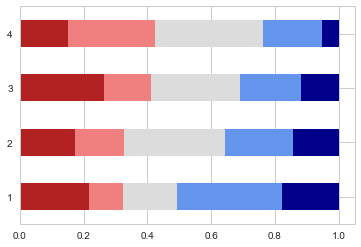

In [103]:
graf_diff_likert(Daten,'A-Q3_3','D-Q2a_neu',1,2,3,4)

n(1)= 130
n(2)= 99
n(3)= 68
n(4)= 60


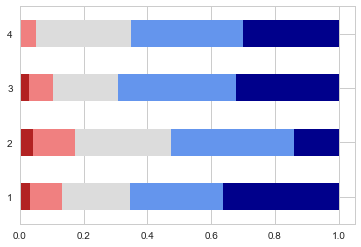

In [104]:
graf_diff_likert(Daten,'A-Q3_29','D-Q2a_neu',1,2,3,4)

n(1)= 130
n(2)= 99
n(3)= 68
n(4)= 60


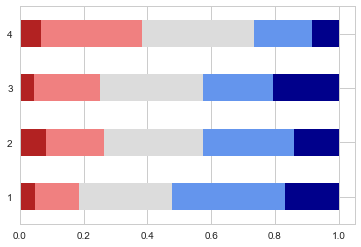

In [105]:
graf_diff_likert(Daten,'A-Q3_24','D-Q2a_neu',1,2,3,4)

##### Studienjahr

##### Niveau des aktuellen Deutschkurses

n(1)= 151
n(2)= 66
n(3)= 103
n(4)= 34
n(5)= 31


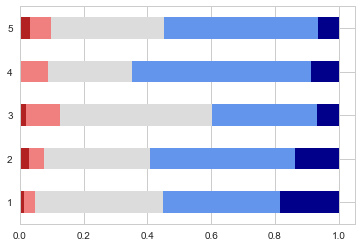

In [106]:
graf_diff_likert(Daten,'A-Q2_2','D-Q4',1,2,3,4,5)

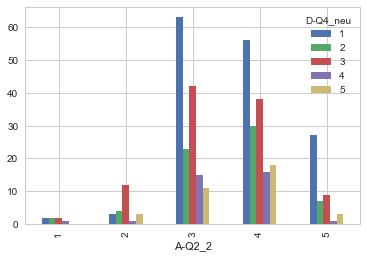

In [107]:
graf_diff(Daten,'A-Q2_2','D-Q4_neu')

##### Sprachkenntnisse

Erstsprachen:

Weitere Sprachkenntnisse:

##### Alter

##### Geschlecht

##### Strategienerwerbskontexte

##### Erhebungssituation

In [108]:
df_test5(Finished,Liste_A_Q2)

,Erh_sit,pilot,Sal,Sev,Vigo,Gran,Sant,Madrid
A-Q2_1,0.000816719,0.324581,0.0347377,0.00345538,0.17905,0.144851,0.0275171,0.41368
A-Q2_2,0.0256985,0.472122,0.309226,0.297906,0.217617,0.309442,0.445325,0.156993
A-Q2_3,0.088275,0.0079671,0.255511,0.000924443,0.00833302,0.00145292,0.0146186,0.18704
A-Q2_4,0.0198049,0.0229425,0.0863551,0.000496374,0.00962004,2.52283e-06,0.0588786,0.486654
A-Q2_5,0.41386,0.154909,0.378542,0.343435,0.131253,0.216758,0.101491,0.453338
A-Q2_6,0.460514,0.158727,0.0423653,0.207288,0.102941,0.000107228,0.406514,0.0490625
A-Q2_7,0.435448,0.0742117,0.012488,0.0731624,0.0573452,0.0408886,0.134172,0.387512


In [109]:
df_test5(Finished,Liste_A_Q3)

,Erh_sit,pilot,Sal,Sev,Vigo,Gran,Sant,Madrid
A-Q3_1,0.12586,0.199015,0.192107,0.203652,0.145319,0.235127,0.138971,0.224403
A-Q3_2,0.121439,0.450572,0.116398,0.429948,0.0503067,0.357954,0.362542,0.0183935
A-Q3_3,0.251325,0.180506,0.243596,0.485032,0.124886,0.0524075,0.188931,0.0255907
A-Q3_4,0.0274144,0.209743,0.00339151,0.29337,0.0646604,0.173642,0.149082,0.0719802
A-Q3_5,0.34708,0.0449219,0.00891158,0.0348891,0.406308,0.434385,0.212784,0.116696
A-Q3_6,0.172319,0.000415862,0.00783744,0.00782035,0.000285832,0.12372,0.40881,0.447574
A-Q3_7,0.339017,1.09681e-05,0.193476,0.00533204,8.23275e-06,0.0359972,0.0719326,0.294362
A-Q3_8,0.218741,0.000104937,0.182167,0.00035361,5.84137e-09,0.0407317,0.0871308,0.225125
A-Q3_9,0.494644,0.000873537,0.173145,0.000212599,2.0455e-06,0.4911,0.134975,0.1732
A-Q3_28,0.0760513,0.0417553,0.112463,0.0431274,0.0373984,0.0710482,0.143885,0.46803


In [110]:
df_test5(Finished,Liste_C_Q1)

,Erh_sit,pilot,Sal,Sev,Vigo,Gran,Sant,Madrid
C-Q1_1,0.351113,0.0267237,0.0139562,0.0386293,0.093078,0.000676253,0.0135616,0.258446
C-Q1_2,0.303934,0.214131,0.0411068,0.169136,0.0401766,0.373529,0.301403,0.354017
C-Q1_3,0.218824,0.00317324,0.015507,0.00389467,0.0198388,0.0134498,0.212621,0.180314
C-Q1_4,0.045695,0.264954,0.446525,0.0419543,0.0840084,0.000847625,0.0916384,0.317937
C-Q1_5,0.0248717,0.128427,0.0907471,0.252174,0.038866,0.0356829,0.0112583,0.253457
C-Q1_6,0.428284,0.476579,0.159215,0.0438809,0.232315,0.194544,0.329528,0.157239
C-Q1_7,0.0573296,0.327756,0.469647,0.0730622,0.302105,0.00135493,0.0370111,0.324258


Nur bei wenigen Items kann ein Einfluss der Erhebungssituation vermutet werden. Die Ergebnisse sind nicht eindeutig, zudem kann der Einfluss auch durch die Erhebung an unterschiedlichen Universitäten zustandekommen. 

Eine weitere besondere Erhebungssituation stellt die Durchführung der Befragung mittels der Papierversion des Fragebogens dar. Die größte Gruppe von Studierenden, die mittels Papierfragebogen befragt wurden, stellt jene der Universität Sevilla (n=56) dar. Im Vergleich der Gruppe aus Sevilla mit den Studierenden anderer Universitäten zeigen sich tatsächlich einige Unterschiede im Antwortverhalten. 

Ein ähnliches Bild zeigt sich jedoch auch, wenn die Analyse mit anderen Universitäten (z.B. Vigo oder Salamanca) durchgeführt wird. 

Ein Einfluss der Verwendung des Papierfragebogens auf das Antwortverhalten kann daher nicht mit Sicherheit festgestellt werden. 

Die Analyse zeigt, dass ein Zusammenhang zwischen bestimmten Items und der Zugehörigkeit der Befragten zu unterschiedlichen Universitäten vorliegt. Allerdings sind mit der Universitätszugehörigkeit auch andere Faktoren wie Studienrichtung und Niveau des besuchten Deutschkurses sowie die Lehrkraft (nicht als Faktor erhoben, aber in der Fachliteratur angenommen) verbunden, sodass keine aussagekräftigen Schlüsse gezogen werden können. 

In [111]:
df_test5(Daten[Daten['Finished']==1],Liste_D[1:])

,Erh_sit,pilot,Sal,Sev,Vigo,Gran,Sant,Madrid
D-Q2,0.160722,0.0159771,0.285282,0.336553,0.054241,0.0711051,0.472767,0.274845
D-Q2a,0.200969,0.151481,0.428047,6.43511e-14,2.7155e-08,0.00898182,0.0142879,2.29032e-05
D-Q2b,0.0431019,0.00189554,0.0388207,0.053178,0.0581966,0.000171853,0.000851664,0.179254
D-Q3,0.000289717,5.66388e-06,0.0333719,2.22978e-07,0.284919,0.0180457,0.0777953,0.189998
D-Q4,0.341895,1.79668e-07,0.00234564,1.39001e-09,1.30969e-12,1.13261e-11,0.000357846,0.359684
D-Q5,0.0188944,0.0201565,0.000634151,0.0293056,6.08285e-05,1.34732e-06,0.0289918,0.0975392
D-Q6,0.389601,0.416359,0.358932,0.1238,0.471244,0.498502,0.404478,0.486454


##### Pilotstudie

In der Folge wird untersucht, ob sich das Antwortverhalten der TN an der Pilotstudie und der Hauptstudie an der Universität Salamanca unterscheidet.

In [112]:
Finished[Finished['D-Q1']==63]['pilot'].value_counts()

0    87
1    65
Name: pilot, dtype: int64

Tatsächlich gibt es Hinweise auf unterschiedliches Antwortverhalten. Dieses kann jedoch durch andere Variablen, die ebenfalls beide Stichproben unterscheiden, zustandegekommen sein.

Als zusätzlicher Test wurden die zuvor dargestellten Analysen auch unter Ausschluss der Teilnehmer der Pilotstudie durchgeführt. Die Ergebnisse unterscheiden sich nicht wesentlich, zum Teil wären weniger Unterschiede zwischen Gruppen (z.B. Studienrichtungen) erkenntlich. Dies lässt vermuten, dass die unterschiedliche Zusammensetzung der Stichprobe mehr Einfluss auf das Antwortverhalten hat als die Verwendung eines geringfügig anders gestalteten Fragebogens. (Die sprachlich abgeänderten Items 12 und 14 zeigen kein verändertes Antwortverhalten.)

### Biplot?

In [116]:
def graf_cplot(data, dim, nclust, dim1 = 0, dim2 = 1, sx = 10, sy = 10):
    
    B = biplot.Classic(data, dim, method = 1) 
    R = B.RowCoord
    C = B.ColCoord
    
    ward = AgglomerativeClustering(n_clusters=nclust).fit(data)
    
    fig = plt.figure(figsize=(sx,sy))
    ax = fig.add_subplot(111)

    sh_v = vector_to_shape(ward.labels_)
    color_v = vector_to_color(ward.labels_)

    for i in range(C.shape[0]):
        ax.arrow(0,0,C[i,dim1],C[i,dim2], alpha = 0.7)
        #ax.scatter(C[i,dim1],C[i,dim2]) # Hier würden Linien nicht angezeigt.
        ax.text(C[i,dim1],C[i,dim2],data.columns[i],fontsize=15, alpha = 0.7)

    for i in range(R.shape[0]):
        ax.scatter(R[i,dim1],R[i,dim2], s = 20, c = color_v[i] , marker = sh_v[i]);

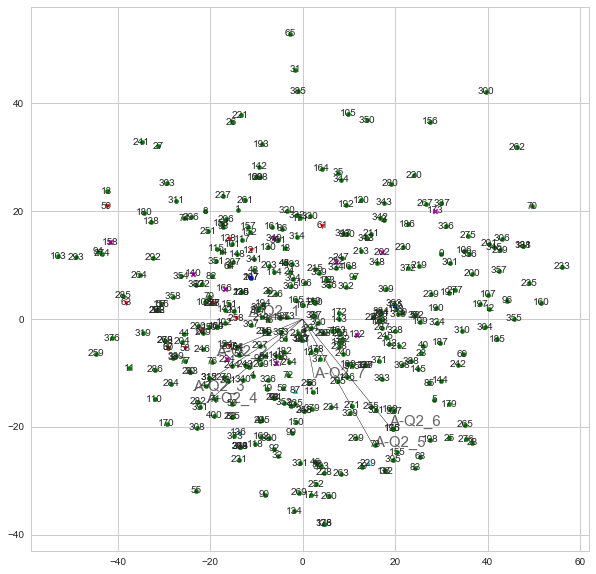

In [129]:
Finished['D-Q2'][87]

3

In [ ]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q2a'])

In [ ]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q2b'])

In [ ]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q3'])

In [ ]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q4'])

In [ ]:
graf_cplot(Daten[Liste_A_Q2],7,6)

In [ ]:
graf_cplot(Daten[Liste_A_Q2],7,6,dim1=0,dim2=2)

In [ ]:
fakt = {'F1': ['A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9','A-Q3_14','A-Q3_15','A-Q3_10'], 
        'F2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
        'F3': ['A-Q3_10','A-Q3_11','A-Q3_12','A-Q3_13'],
        'F4': ['A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19'],
        'F5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24'],
        'F6': ['A-Q3_26','A-Q3_27','A-Q3_30','A-Q3_31'],
        'F7': ['A-Q3_20','A-Q3_28','A-Q3_29']}

Ergebnisse der Faktorenanalyse (mit R durchgeführt)

In [ ]:
graf_biplot(Finished[fakt['F1']],7,Finished['D-Q4_neu'])

In [ ]:
graf_biplot(Finished[fakt['F2']],5,Finished['D-Q4'])

In [ ]:
graf_biplot(Finished[fakt['F3']],4,Finished['D-Q4'])